In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import geopandas
import pandas
import pathlib
import numpy
import matplotlib
import seaborn
import shapely
import rioxarray
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [2]:
resolution = 10
horizontal_crs = 2193

### Load in GeoFabrics Bathymetry estimates

In [26]:
cache_path = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\Waikanae\caches\Wellington_2013\measured_river")
dem_river = rioxarray.rioxarray.open_rasterio(cache_path / "dem_10m_rivers_and_oceans.nc", masked=True).squeeze("band", drop=True)
dem_no_river = rioxarray.rioxarray.open_rasterio(cache_path / "dem_10m_oceans.nc", masked=True).squeeze("band", drop=True)

In [27]:
river_centreline = geopandas.read_file(cache_path / "aligned_channel_100000000.geojson")
river_polygon = geopandas.read_file(cache_path / "river_polygon.geojson")

## Load in Measured cross sections
See raw cell below for converting to NZVD2016. This has already been done so load in the converted one directly

In [28]:
measured_sections = geopandas.read_file(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Waikanae/Waikanae_Cross_Sections_NIWA/2014_Survey_XS_NZVD2016.geojson")

In [29]:
measured_sections.head(2)

,Number,Source,Section,Offset,Northing,Easting,Level,Code,Date,Upstream,lvd_conversion,z_2016,geometry
0,10001.0,C,10.0,0.00,6035173.66,2679120.52,2.52,CP,20141022.0,0.0,0.356669,2.163331,POINT Z (1769102.282 5473458.894 2.163)
1,10002.0,F,10.0,0.09,6035173.75,2679120.55,2.59,SH,20141022.0,0.0,0.356669,2.233331,POINT Z (1769102.312 5473458.984 2.233)


### Simplify the measured points to min point/line strings

In [30]:
measured_centres = {'Section': [], 'geometry': []}
measured_lines = {'Section': [], 'geometry': [], 'min_elevation': []}
for section in measured_sections['Section'].unique():
    measured_section = measured_sections[measured_sections['Section'] == section]
    measured_centre = measured_section[measured_section['Level']==measured_section['Level'].min()].iloc[0]
    measured_centres['Section'].append(section)
    measured_centres['geometry'].append(measured_centre['geometry'])
    
    measured_lines['Section'].append(section)
    measured_lines['geometry'].append(shapely.geometry.LineString( [[measure_point.x, measure_point.y, measure_point.z] for measure_point in measured_section.geometry.values] ))
    measured_lines['min_elevation'].append(measured_section['Level'].min())
measured_centres = geopandas.GeoDataFrame(measured_centres, crs=horizontal_crs)
measured_lines = geopandas.GeoDataFrame(measured_lines, crs=horizontal_crs)

## Sample DEM for elevations
Record the Bias and STDev for each cross section against the two DEMS

<AxesSubplot:>

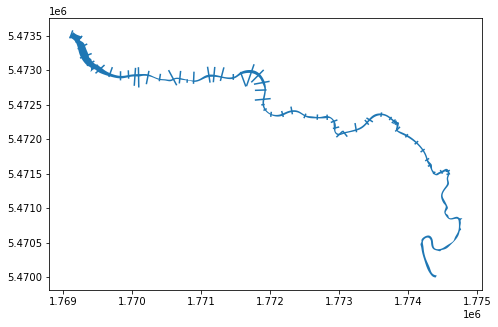

In [31]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(10, 5))
river_polygon.plot(ax=ax)
measured_lines.plot(ax=ax)

# Sample every 1m
Use Linear interpolation in between

In [32]:
comparisons_sampled = {"Unconditioned DEM z": [], "Conditioned DEM z": [], "Measured Section z": [], "Section": [], "River": [], "Distance Upstream [m]": [], "Offset [m]": []}
for index, row in measured_lines.iterrows():
    print(f"Section number = {index}")
    line = row.geometry
    distance_upstream = float(river_centreline.project(measured_centres.iloc[index].geometry))
    for offset in list(range(int(numpy.ceil(line.length)))):
        point = line.interpolate(offset)
        comparisons_sampled["Unconditioned DEM z"].append(float(dem_no_river.z.interp(x=point.x, y=point.y)))
        comparisons_sampled["Conditioned DEM z"].append(float(dem_river.z.interp(x=point.x, y=point.y)))
        comparisons_sampled["Measured Section z"].append(point.z)
        comparisons_sampled["Section"].append(row['Section'])
        comparisons_sampled["River"].append(river_polygon.iloc[0].geometry.contains(point))
        comparisons_sampled["Distance Upstream [m]"].append(distance_upstream)
        comparisons_sampled["Offset [m]"].append(offset)
        
comparisons_sampled = pandas.DataFrame.from_dict(comparisons_sampled)

Section number = 0
Section number = 1
Section number = 2
Section number = 3
Section number = 4
Section number = 5
Section number = 6
Section number = 7
Section number = 8
Section number = 9
Section number = 10
Section number = 11
Section number = 12
Section number = 13
Section number = 14
Section number = 15
Section number = 16
Section number = 17
Section number = 18
Section number = 19
Section number = 20
Section number = 21
Section number = 22
Section number = 23
Section number = 24
Section number = 25
Section number = 26
Section number = 27
Section number = 28
Section number = 29
Section number = 30
Section number = 31
Section number = 32
Section number = 33
Section number = 34
Section number = 35
Section number = 36
Section number = 37
Section number = 38
Section number = 39
Section number = 40
Section number = 41
Section number = 42
Section number = 43
Section number = 44
Section number = 45
Section number = 46
Section number = 47
Section number = 48
Section number = 49
Section nu

## Bed elevation errors
95% confidence interval plot for the errors along each section in the river

In [33]:
comparisons_sampled["Unconditioned DEM Elevation Errors"] = comparisons_sampled["Unconditioned DEM z"] - comparisons_sampled["Measured Section z"]
comparisons_sampled["Conditioned DEM Elevation Errors"] = comparisons_sampled["Conditioned DEM z"] - comparisons_sampled["Measured Section z"]

In [34]:
comparisons_sampled.head(1)

,Unconditioned DEM z,Conditioned DEM z,Measured Section z,Section,River,Distance Upstream [m],Offset [m],Unconditioned DEM Elevation Errors,Conditioned DEM Elevation Errors
0,1.861881,1.763021,2.163331,10.0,False,0.0,0,-0.30145,-0.400309


In [134]:
comparisons_for_plotting=comparisons_sampled.rename(
    columns={"Unconditioned DEM Elevation Errors": "Unconditioned DEM", "Conditioned DEM Elevation Errors": "Conditioned DEM"}).drop(
    columns=["Unconditioned DEM z", "Conditioned DEM z", "Measured Section z"]).melt(
    id_vars=["Section", "Distance Upstream [m]", "River", "Offset [m]"], var_name="Comparison", value_name="Riverbed Elevation Error [m]")

In [36]:
comparisons_for_plotting.head(1)

,Section,Distance Upstream [m],River,Offset [m],Comparison,Riverbed Elevation Error [m]
0,10.0,0.0,False,0,Unconditioned DEM,-0.30145


[Text(0.5, 1.0, 'Section Depths Comparison 95% CI')]

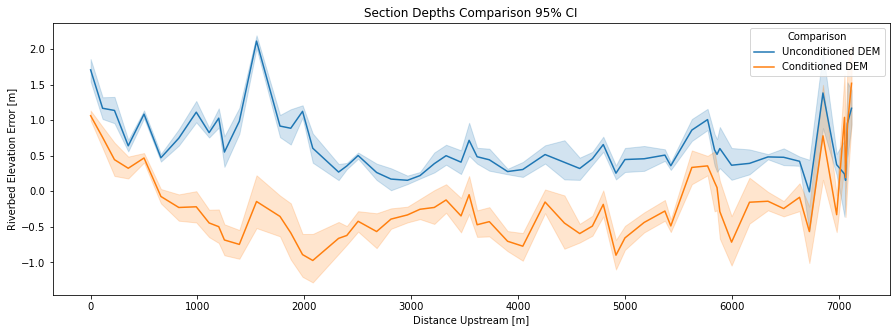

In [189]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(15, 5))
seaborn.lineplot(ax=ax, data=comparisons_for_plotting[comparisons_for_plotting["River"]], x="Distance Upstream [m]", y="Riverbed Elevation Error [m]", hue="Comparison").set(title='Section Depths Comparison 95% CI')

# Channel Area error
The total area of the channel at each section

In [163]:
channel_depths = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=["Unconditioned DEM Elevation Errors", "Conditioned DEM Elevation Errors", "River", "Section"]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
section_max_evaluation = channel_depths.groupby("Distance Upstream [m]")[["Measured Section z"]].max()

In [164]:
channel_depths.head(5)

Unconditioned DEM z  Conditioned DEM z  \
Distance Upstream [m] Offset [m]                                           
0.0                   10                     1.207450           1.066715   
                      11                     1.141482           1.009527   
                      12                     1.080738           0.951801   
                      13                     1.025176           0.893286   
                      14                     0.974750           0.833906   

                                  Measured Section z  
Distance Upstream [m] Offset [m]                      
0.0                   10                    0.859929  
                      11                    0.246071  
                      12                    0.044293  
                      13                    0.030140  
                      14                    0.041389

In [183]:
# Some hacky code to subtract the max elevation from each column in turn
channel_depths["Measured Section"] = section_max_evaluation - channel_depths[["Measured Section z"]]
channel_depths["Unconditioned DEM"] = section_max_evaluation.rename(columns={"Measured Section z": "Unconditioned DEM z"}) - channel_depths[["Unconditioned DEM z"]]
channel_depths["Conditioned DEM"] = section_max_evaluation.rename(columns={"Measured Section z": "Conditioned DEM z"}) - channel_depths[["Conditioned DEM z"]]
channel_depths.head(2)

Unconditioned DEM z  Conditioned DEM z  \
Distance Upstream [m] Offset [m]                                           
0.0                   10                     1.207450           1.066715   
                      11                     1.141482           1.009527   

                                  Measured Section z  Measured Section  \
Distance Upstream [m] Offset [m]                                         
0.0                   10                    0.859929          0.000000   
                      11                    0.246071          0.613858   

                                  Unconditioned DEM  Conditioned DEM  
Distance Upstream [m] Offset [m]                                      
0.0                   10                  -0.347521        -0.206786  
                      11                  -0.281553        -0.149598

In [184]:
channel_area = channel_depths.drop(
    columns=["Measured Section z", "Unconditioned DEM z", "Conditioned DEM z"]).groupby("Distance Upstream [m]").sum()
channel_area.head(1)

,Measured Section,Unconditioned DEM,Conditioned DEM
Distance Upstream [m],,,
0.0,85.199945,8.401809,37.384879


In [185]:
areas_for_plotting=channel_area.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Riverbed Area [m^2]")

[Text(0.5, 1.0, 'Channel Area Comparison')]

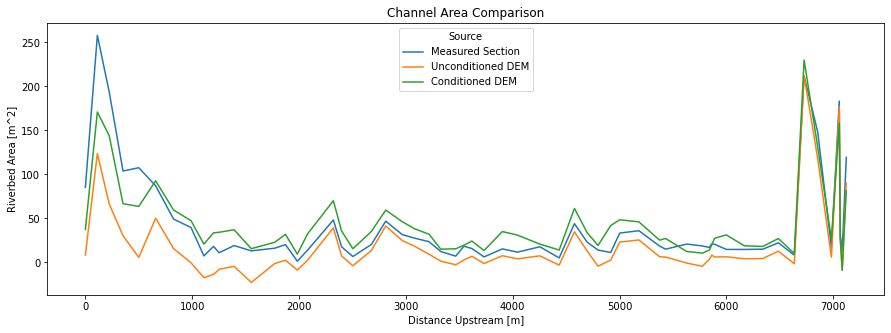

In [188]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(15, 5))
seaborn.lineplot(ax=ax, data=areas_for_plotting, x="Distance Upstream [m]", y="Riverbed Area [m^2]", hue="Source").set(title='Channel Area Comparison')

In [182]:
unconditioned_error = channel_area["Unconditioned DEM"]-channel_area["Measured Section"]
conditioned_error = channel_area["Conditioned DEM"]-channel_area["Measured Section"]

area_summary = pandas.DataFrame([[unconditioned_error.mean(), conditioned_error.mean()], [unconditioned_error.std(), conditioned_error.std()]], index = ["Mean Error", "Standard Deviation"], columns=["Unconditioned DEM", "Conditioned DEM"])
area_summary

,Unconditioned DEM,Conditioned DEM
Mean Error,-22.010939,1.877762
Standard Deviation,27.278951,21.138275


# Plot difference in area plot

In [192]:
channel_area_difference = pandas.DataFrame()
channel_area_difference["Unconditioned DEM"] = channel_area["Unconditioned DEM"]-channel_area["Measured Section"]
channel_area_difference["Conditioned DEM"] = channel_area["Conditioned DEM"]-channel_area["Measured Section"]
channel_area_difference.head(1)

,Unconditioned DEM,Conditioned DEM
Distance Upstream [m],,
0.0,-76.798137,-47.815067


In [197]:
area_diffs_for_plotting=channel_area_difference.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Cross-sectional Area [m^2]")
area_diffs_for_plotting.head(2)

,Distance Upstream [m],Source,Cross-sectional Area [m^2]
0,0.000000,Unconditioned DEM,-76.798137
1,112.196064,Unconditioned DEM,-134.182429


[Text(0.5, 1.0, 'Channel Area Error')]

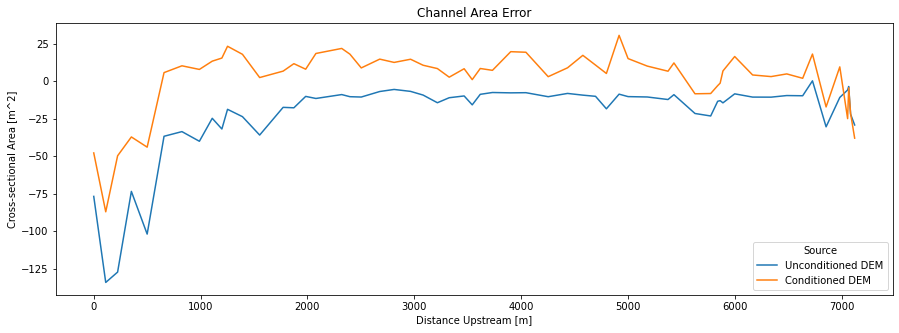

In [199]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(15, 5))
seaborn.lineplot(ax=ax, data=area_diffs_for_plotting, x="Distance Upstream [m]", y="Cross-sectional Area [m^2]", hue="Source").set(title='Channel Area Error')

In [82]:
t["t"]

Distance Upstream [m]  Offset [m]
0.000000               10           NaN
                       11           NaN
                       12           NaN
                       13           NaN
                       14           NaN
                                     ..
7121.269378            40           NaN
                       41           NaN
                       42           NaN
                       43           NaN
                       44           NaN
Name: t, Length: 1924, dtype: float64

In [84]:
t.set_index(channel_area.groupby("Distance Upstream [m]")["Measured Section z"].max())

ValueError: Length mismatch: Expected 1924 rows, received array of length 59

In [57]:
channel_area.sub(pandas.DataFrame(section_max_evaluation), level=0)

Conditioned DEM z  Measured Section z  \
Distance Upstream [m] Offset [m]                                          
0.000000              10                        NaN            0.000000   
                      11                        NaN           -0.613858   
                      12                        NaN           -0.815636   
                      13                        NaN           -0.829789   
                      14                        NaN           -0.818540   
...                                             ...                 ...   
7121.269378           40                        NaN           -5.311490   
                      41                        NaN           -4.807884   
                      42                        NaN           -4.525262   
                      43                        NaN           -2.262631   
                      44                        NaN            0.000000   

                                  Unconditioned DEM z  
Distance Upstream [m] Offset [m]                       
0.000000              10                          NaN  
                      11                          NaN  
                      12                          NaN  
                      13                          NaN  
                      14                          NaN  
...                                               ...  
7121.269378           40                          NaN  
                      41                          NaN  
                      42                          NaN  
                      43                          NaN  
                      44                          NaN  

[1924 rows x 3 columns]

In [47]:
channel_area.groupby("Distance Upstream [m]")["Measured Section z"].max().index

Float64Index([               0.0, 112.19606426344153,   223.289415667003,
              352.14311436113866, 499.88604355622914,  657.8103912369844,
               825.4144635539351,  988.7316540555153, 1109.0592468595646,
              1199.1836843971696, 1252.2082463176732, 1391.8137670321846,
              1552.7966513330466, 1772.3539425859644,  1872.987533686414,
              1983.5165820835114, 2079.1399450513345,  2320.833087490915,
              2397.6459771394957, 2503.6222333171263,  2676.621342457075,
               2811.140025214295,  2965.155674380145,  3082.405384558699,
              3216.2457178935074, 3326.7354377681067, 3466.5043394647455,
              3542.2171871928235,  3617.265222305055,  3731.497496139898,
              3902.5208742117134,  4044.653751589085,  4253.161582882518,
               4434.200847147581,  4577.409446970321,  4696.145188214034,
               4797.871065795796,  4916.656276319338,    5000.7529914217,
               5180.388869465768, 5374

In [43]:
channel_area.groupby("Distance Upstream [m]")["Measured Section z"].max()

Distance Upstream [m]
0.000000        0.859929
112.196064      1.663631
223.289416      1.355159
352.143114      0.667017
499.886044      0.696159
657.810391      1.029752
825.414464      0.899259
988.731654      1.011257
1109.059247     0.225827
1199.183684     0.745079
1252.208246     0.609138
1391.813767     0.995501
1552.796651     0.893848
1772.353943     1.579208
1872.987534     1.771362
1983.516582     1.156908
2079.139945     2.141157
2320.833087     3.929473
2397.645977     3.281097
2503.622233     3.085843
2676.621342     4.083755
2811.140025     5.503785
2965.155674     5.469646
3082.405385     5.935190
3216.245718     6.173661
3326.735438     6.123085
3466.504339     6.413334
3542.217187     6.922433
3617.265222     7.498260
3731.497496     7.316208
3902.520874     8.702716
4044.653752     9.093160
4253.161583    10.171856
4434.200847    10.667434
4577.409447    12.612350
4696.145188    12.622545
4797.871066    12.959553
4916.656276    13.842681
5000.752991    15.265268
518

# Plot the bias and stdev for each full cross section
Calculate the distance upstream - intersection with smoothed centreline

In [ ]:
comparisons_all[["Unconditioned DEM bias", "Conditioned DEM bias"]].mean()

In [ ]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(20, 5))

matplotlib.pyplot.ylim([-2, 2])
#plt.show()

comparisons_all[["Unconditioned DEM bias"]].plot(ax=ax, yerr=comparisons_all["Unconditioned DEM std"], capsize=2)
comparisons_all[["Conditioned DEM bias"]].plot(ax=ax, yerr=comparisons_all["Conditioned DEM std"], capsize=2)
#ax.yaxis.grid(True)
ax.spines['bottom'].set_position('zero')

## Plot nearest sections

In [ ]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(10, 15))

measured_lines.plot(ax=ax, color='b')
#nearest_depths.plot(ax=ax, color='m')
nearest_sections.plot(ax=ax, color='r')

## Update the index to be metres upstream

In [ ]:
# Add the Upstream distance to the comprison sections
distance_upstream = nearest_depths.index * sampled_section_spacing
measured_lines.insert(loc=0, column='Distance Upstream', value=distance_upstream + measured_lines["Signed Distances"])
measured_lines = measured_lines.set_index(['Distance Upstream'])
nearest_depths.insert(loc=0, column='Distance Upstream', value=distance_upstream)
nearest_sections.insert(loc=0, column='Distance Upstream', value=distance_upstream)
nearest_depths = nearest_depths.set_index(['Distance Upstream'])
nearest_sections = nearest_sections.set_index(['Distance Upstream'])

In [ ]:
# Add the Upstream distance to the comprison sections
distance_upstream = depths.index * sampled_section_spacing
depths.insert(loc=0, column='Distance Upstream', value=distance_upstream)
depths = depths.set_index(['Distance Upstream'])
estimated_sections.insert(loc=0, column='Distance Upstream', value=distance_upstream)
estimated_sections = estimated_sections.set_index(['Distance Upstream'])

In [ ]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(15, 10))

depths[[rupp_bed_elevation_name, neal_bed_elevation_name]].plot(ax=ax)
nearest_depths[[rupp_bed_elevation_name, neal_bed_elevation_name]].plot(ax=ax, linestyle="--")
estimated_sections[["min_z_centre_unimodal"]].plot(ax=ax, color='r')

## Plot lowest best elevation 
Specify distance upstream with time

In [ ]:
measured_sections.head(5)

In [ ]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(20, 10))

nearest_depths[[rupp_bed_elevation_name, neal_bed_elevation_name]].plot(ax=ax, color='b')
measured_lines[["min_elevation"]].plot(ax=ax, color='r')
nearest_sections[["min_z_centre_unimodal"]].plot(ax=ax)

In [ ]:
nearest_depths[[rupp_bed_elevation_name, neal_bed_elevation_name]].head(5)

In [ ]:
nearest_sections["min_z_centre_unimodal"].head()

In [ ]:
(nearest_depths[rupp_bed_elevation_name]-nearest_sections["min_z_centre_unimodal"]).plot

In [ ]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(20, 10))

#(nearest_depths[[rupp_bed_elevation_name, neal_bed_elevation_name]]-nearest_sections[["min_z_centre_unimodal"]]).plot(ax=ax, color='b')
(nearest_depths[rupp_bed_elevation_name]-nearest_sections["min_z_centre_unimodal"]).plot(ax=ax)
(nearest_depths[neal_bed_elevation_name]-nearest_sections["min_z_centre_unimodal"]).plot(ax=ax)
#(measured_lines[["min_elevation"]]-nearest_sections["min_z_centre_unimodal"]).plot(ax=ax, color='r')
#nearest_sections[["min_z_centre_unimodal"]].plot(ax=ax)

#### Calculated propely
Calculate area from where each section goes below the water surface (even if between two measurement sites)

In [ ]:
def zero_crossing(x_pos: float, x_neg: float, y_pos: float, y_neg: float):
    x_zc = x_pos * -y_neg / (y_pos - y_neg) + x_neg * y_pos / (y_pos - y_neg)
    return x_zc

In [ ]:
def measured_area(depth_name):
    measured_area = []
    
    for index, row in nearest_widths.iterrows():
        section = cross_sections[cross_sections['Section'] == row['Section']]
        section = section.reset_index(drop=True)
        water_elevation = row[water_elevation_name]
        area = 0
        for i in range(len(section) - 1):
            if section[depth_name][i] >= 0 and section[depth_name][i + 1] >= 0:
                # calculate Raimann square area
                area += (section['Offset'][i + 1] - section['Offset'][i]) * (section[depth_name][i] + section[depth_name][i + 1]) / 2
            elif section[depth_name][i] > 0:
                # Calculate from the left - right is above
                offset_crossing = zero_crossing(x_pos=section['Offset'][i + 1], x_neg=section['Offset'][i],
                                                y_pos=section[depth_name][i + 1], y_neg=section[depth_name][i]) 
                area += (offset_crossing - section['Offset'][i]) * section[depth_name][i] / 2
            elif section[depth_name][i + 1] > 0:
                # Calculate from the right - left is above
                offset_crossing = zero_crossing(x_pos=section['Offset'][i], x_neg=section['Offset'][i + 1],
                                                y_pos=section[depth_name][i], y_neg=section[depth_name][i + 1]) 
                area += (section['Offset'][i + 1] - offset_crossing) * section[depth_name][i + 1] / 2
        measured_area.append(area)
    return measured_area

In [ ]:
measured_normal_area = measured_area('normal_depth')
measured_flood_area = measured_area('flood_depth')
nearest_areas.insert(loc=0, column='Measured normal areas', value=measured_normal_area)
nearest_areas.insert(loc=0, column='Measured flood areas', value=measured_flood_area)

In [ ]:
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,6))
nearest_areas.plot(ax=axs[0])
areas.plot(ax=axs[1])

In [ ]:
cross_sections[[water_elevation_name, threshold_name]].plot()

In [ ]:
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,6))
nearest_areas.plot(ax=axs[0])
areas.plot(ax=axs[1])

In [ ]:
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,6))
nearest_areas.plot(ax=axs[0])
areas.plot(ax=axs[1])

## Plot bed elevations and depths of the two approaches

In [ ]:
f, axs = matplotlib.pyplot.subplots(1, 2, figsize=(15, 6))

nearest_widths.set_index('Section', drop=True)[water_elevation_name].plot(ax=axs[0], label='Water surface elevation')
nearest_depths.set_index('Section', drop=True)['bed_elevation_Neal_et_al'].plot(ax=axs[0], label='Bed elevation calculated Neal et al')
nearest_depths.set_index('Section', drop=True)['bed_elevation_Rupp_and_Smart'].plot(ax=axs[0], label='Bed elevation calculated Rupp & Smart')
cross_sections.groupby('Section')['z_2016'].min().plot(ax=axs[0], label='Measured cross-section')
axs[0].set(title="Bed elevations estimated and measured", xlabel="Transect number where there are measured cross sections", ylabel="River bed elevation in m")
axs[0].legend()

nearest_depths.set_index('Section', drop=True)[neal_depth_name].plot(ax=axs[1], label='Calculated Neal et al depth')
nearest_depths.set_index('Section', drop=True)[rupp_depth_name].plot(ax=axs[1], label='Calculated Rupp & Smart depth')
cross_sections.groupby('Section')['depth'].max().plot(ax=axs[1], label='Measured cross-section')
axs[1].set(title="Bed depths estimated and measured", xlabel="Transect number where there are measured cross sections", ylabel="River depths in m")
axs[1].legend()

## Plot cross sections

In [ ]:
cross_sections[[water_elevation_name, 'z_2016']].plot(figsize=(15, 6))
matplotlib.pyplot.yticks(ticks=[-2.5, 0, 2.5, 10, 20, 30, 40]);
matplotlib.pyplot.grid(axis="y")

In [ ]:
f, axs = matplotlib.pyplot.subplots(2, 4, figsize=(30, 12), sharey=True)
for key, group in cross_sections.groupby('Section'):
    (-group['depth']).reset_index(drop=True).plot(ax=axs[int(key/10/28), int((key/10 - 28)/7)], label=f"{key}")
for axi in axs:
    for axij in axi:
        axij.legend()

In [ ]:
f, axs = matplotlib.pyplot.subplots(2, 4, figsize=(30, 12), sharey=True)

for key, group in cross_sections.groupby('Section'):
    group = group.copy(deep=True)
    group.loc[group['depth'] < 0, 'depth'] = numpy.nan
    (-group['depth']).reset_index(drop=True).plot(ax=axs[int(key/10/28), int((key/10 - 28)/7)], label=f"{key}")
    #print(f"key={key}, f{group['depth'].values}")
for axi in axs:
    for axij in axi:
        axij.legend()

In [ ]:
cross_sections.groupby('Section')['depth'].plot();

In [ ]:
cross_sections.groupby('Section')['z_2016'].plot();

### Plots exploring the change to width to produce an expected bed elevation

In [ ]:
fudge_factor = 2
depth_wider = (nearest_key_parameters['mannings_n'] * nearest_key_parameters['flow'] / (numpy.sqrt(nearest_key_parameters['slope']) * nearest_key_parameters['widths_Savgol'] * fudge_factor)) ** (3/5) - threshold

f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_centre_unimodal']-depth_wider).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_centre_unimodal_0.5km_rolling_mean'] - depth_wider).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z_centre']-depth_wider).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title=f"Depths estimated using the Uniform Flow Throery approach with width mutiplier of {fudge_factor}")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()